<div dir="rtl" style="color:red; font-size:1.2em; font-weight:bold; text-align:center;">
You should run phase 2 before running this phase
</div>


# Phase 4: Uncertainty & Sales Classification

What we are doing in this phase is expanding our forecasting capabilities beyond simple point predictions. 

This phase is divided into three main components:
1. **Direct Multi-Step Forecasting**: Predicting sales for the next 7 days ($t+1$ to $t+7$) using a direct approach to completely eliminate error propagation.
2. **Uncertainty Estimation**: Using Quantile Regression to provide statistical confidence intervals (e.g., 10th and 90th percentiles) alongside our median forecast.
3. **Sales Classification**: Transforming the continuous sales prediction problem into a multi-class classification task (Low, Medium, High) to provide actionable business categories.

## 0) Setup and Data Loading

What we are doing here is setting up our environment and loading the engineered data from Phase 2. 
We rely solely on the pre-split `.pkl` files (`train_split`, `val_split`, `test_split`) to ensure strict chronological ordering and avoid any data leakage.


In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Machine Learning models
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize

# Visualization settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

# Set seeds for reproducibility
np.random.seed(42)

# Load the Phase 2 engineered data
base_path = Path('../data/phase2_output/pkl')

print("Loading data...")
train_df = pd.read_pickle(base_path / 'train_split.pkl')
val_df = pd.read_pickle(base_path / 'val_split.pkl')
test_df = pd.read_pickle(base_path / 'test_split.pkl')

# Ensure Date is datetime and sort properly to respect time-series structure
for frame in (train_df, val_df, test_df):
    frame['Date'] = pd.to_datetime(frame['Date'])

train_df = train_df.sort_values(['Store', 'Date']).reset_index(drop=True)
val_df = val_df.sort_values(['Store', 'Date']).reset_index(drop=True)
test_df = test_df.sort_values(['Store', 'Date']).reset_index(drop=True)

print('-' * 40)
print('Train shape:', train_df.shape)
print('Val shape  :', val_df.shape)
print('Test shape :', test_df.shape)
print('-' * 40)

# Verify date ranges to ensure no overlap/leakage
print(f"Train Date Range: {train_df['Date'].min().date()} to {train_df['Date'].max().date()}")
print(f"Val Date Range  : {val_df['Date'].min().date()} to {val_df['Date'].max().date()}")
print(f"Test Date Range : {test_df['Date'].min().date()} to {test_df['Date'].max().date()}")

# Display the first few rows of the test set
test_df[['Store', 'Date', 'Sales', 'Open']].head()


Loading data...
----------------------------------------
Train shape: (794209, 157)
Val shape  : (103695, 157)
Test shape : (103695, 157)
----------------------------------------
Train Date Range: 2013-01-01 to 2015-01-12
Val Date Range  : 2015-01-13 to 2015-04-15
Test Date Range : 2015-04-16 to 2015-07-17


,Store,Date,Sales,Open
0,1,2015-04-16,4116,1
1,1,2015-04-17,4718,1
2,1,2015-04-18,4594,1
3,1,2015-04-19,0,0
4,1,2015-04-20,3722,1


## 1) Direct Multi-Step Forecasting (1 to 7 Days Ahead)

What we are doing here is forecasting sales for the next 7 days without feeding predictions back into the model. This is called the **Direct Approach**. 

If we use a recursive approach (predicting tomorrow, then using that prediction as a feature for the day after), errors compound quickly. Instead, we train 7 distinct models. 
For a model predicting $h$ days ahead, we must ensure it only sees historical data available $h$ days prior. We achieve this by shifting all dynamic features (lags and rolling statistics) forward by $h-1$ days, while keeping the static calendar features (like `DayOfWeek`, `Promo`) aligned with the target day since these are known in advance.

### Steps:
1. Identify all dynamic features (lags, rolling means, rolling stds).
2. For each horizon $h \in [1, 7]$, shift these dynamic features by $h-1$.
3. Train a distinct `LightGBM` model for each horizon.
4. Evaluate and plot how the forecast error grows as we look further into the future.


Total features: 150
Dynamic features to shift: 62
Static/Calendar features: 88

Training Direct Multi-Step Models...
--------------------------------------------------
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14086
[LightGBM] [Info] Number of data points in the train set: 794209, number of used features: 143
[LightGBM] [Info] Start training from score 5736.942071
Horizon t+1 | RMSE: 745.03 | MAPE: 0.0821 | R2: 0.9638
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14086
[LightGBM] [Info] Number of data points in the train set: 794209, number of used features: 143
[LightGBM

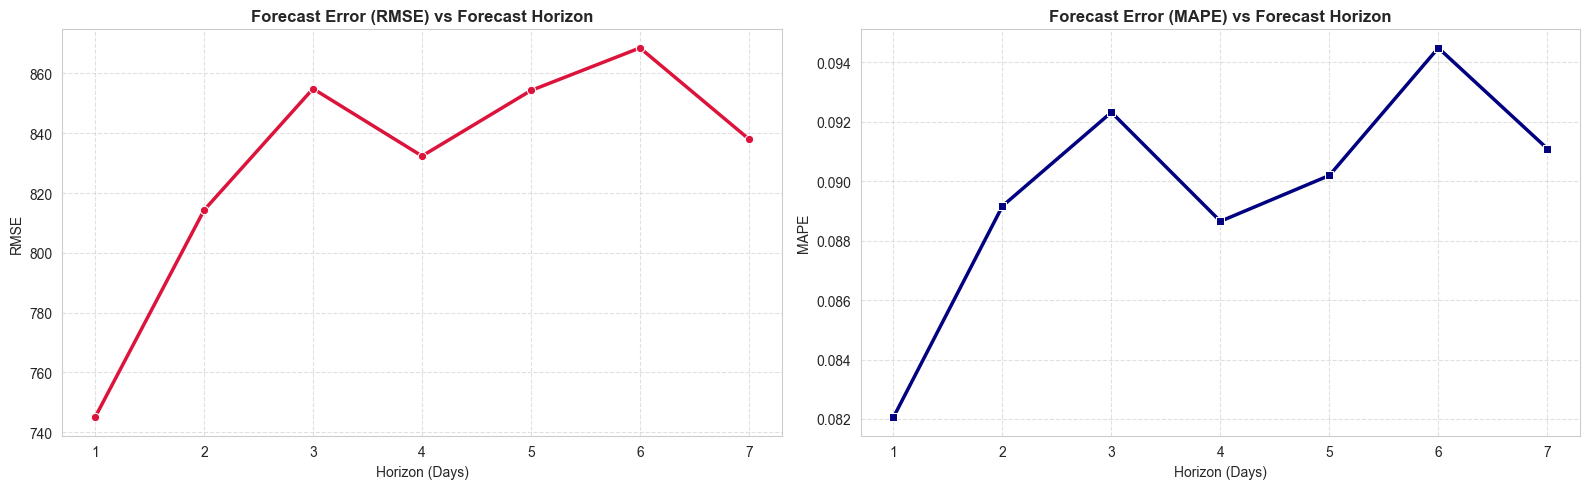

In [2]:
import re

# --- FIX: Clean column names to remove special JSON characters for LightGBM ---
def clean_col_names(df):
    return df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '_', x))

train_df = clean_col_names(train_df)
val_df = clean_col_names(val_df)
test_df = clean_col_names(test_df)
# -------------------------------------------------------------------------------

# 1. Identify features and target
target = 'Sales'
# Exclude target, future-leaking columns, and identifiers
exclude_cols = ['Date', 'Sales', 'Customers', 'Id', 'IdRaw', 'Store', 'StoreRaw']
base_features = [c for c in train_df.columns if c not in exclude_cols]

# Identify dynamic features that need shifting for multi-step forecasting
# These are features that rely on recent past data
dynamic_features = [c for c in base_features if 'lag' in c or 'roll' in c]
static_features = [c for c in base_features if c not in dynamic_features]

print(f"Total features: {len(base_features)}")
print(f"Dynamic features to shift: {len(dynamic_features)}")
print(f"Static/Calendar features: {len(static_features)}\n")

# 2. Setup structures to store results
horizons = list(range(1, 8))
results = []
models_dict = {}

print("Training Direct Multi-Step Models...")
print("-" * 50)

for h in horizons:
    # We copy the splits to avoid modifying the original data
    X_train_h = train_df.copy()
    X_val_h = val_df.copy()
    X_test_h = test_df.copy()
    
    # Shift dynamic features by (h-1) per Store
    # If h=1, shift is 0 (predicting tomorrow using today).
    # If h=3, shift is 2 (predicting 3 days ahead using data from 3 days ago).
    shift_periods = h - 1
    
    if shift_periods > 0:
        for df_h in [X_train_h, X_val_h, X_test_h]:
            df_h[dynamic_features] = df_h.groupby('Store')[dynamic_features].shift(shift_periods)
            df_h[dynamic_features] = df_h.groupby('Store')[dynamic_features].ffill().fillna(0)

    
    # Extract X and y
    y_train = X_train_h[target]
    X_train = X_train_h[base_features]
    
    y_val = X_val_h[target]
    X_val = X_val_h[base_features]
    
    y_test = X_test_h[target]
    X_test = X_test_h[base_features]
    
    # Train LightGBM Model
    model = lgb.LGBMRegressor(
        n_estimators=600,
        learning_rate=0.08,
        max_depth=8,
        random_state=42,
        n_jobs=-1
    )
    
    # Using callbacks for early stopping to avoid warnings in newer LightGBM versions
    callbacks = [lgb.early_stopping(stopping_rounds=50, verbose=False)]
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        callbacks=callbacks
    )
    
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Evaluate
    # We calculate MAPE only on open days (Sales > 0) to avoid infinite values
    mask = y_test > 0
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test[mask], y_pred[mask])
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        'Horizon (Days)': h,
        'RMSE': rmse,
        'MAPE': mape,
        'R2': r2
    })
    
    models_dict[h] = model
    print(f"Horizon t+{h} | RMSE: {rmse:.2f} | MAPE: {mape:.4f} | R2: {r2:.4f}")

print("-" * 50)

# 3. Visualize the Error Propagation
results_df = pd.DataFrame(results)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot RMSE
sns.lineplot(data=results_df, x='Horizon (Days)', y='RMSE', marker='o', color='crimson', ax=axes[0], linewidth=2.5)
axes[0].set_title('Forecast Error (RMSE) vs Forecast Horizon', fontsize=12, fontweight='bold')
axes[0].set_xticks(horizons)
axes[0].grid(True, linestyle='--', alpha=0.6)

# Plot MAPE
sns.lineplot(data=results_df, x='Horizon (Days)', y='MAPE', marker='s', color='navy', ax=axes[1], linewidth=2.5)
axes[1].set_title('Forecast Error (MAPE) vs Forecast Horizon', fontsize=12, fontweight='bold')
axes[1].set_xticks(horizons)
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


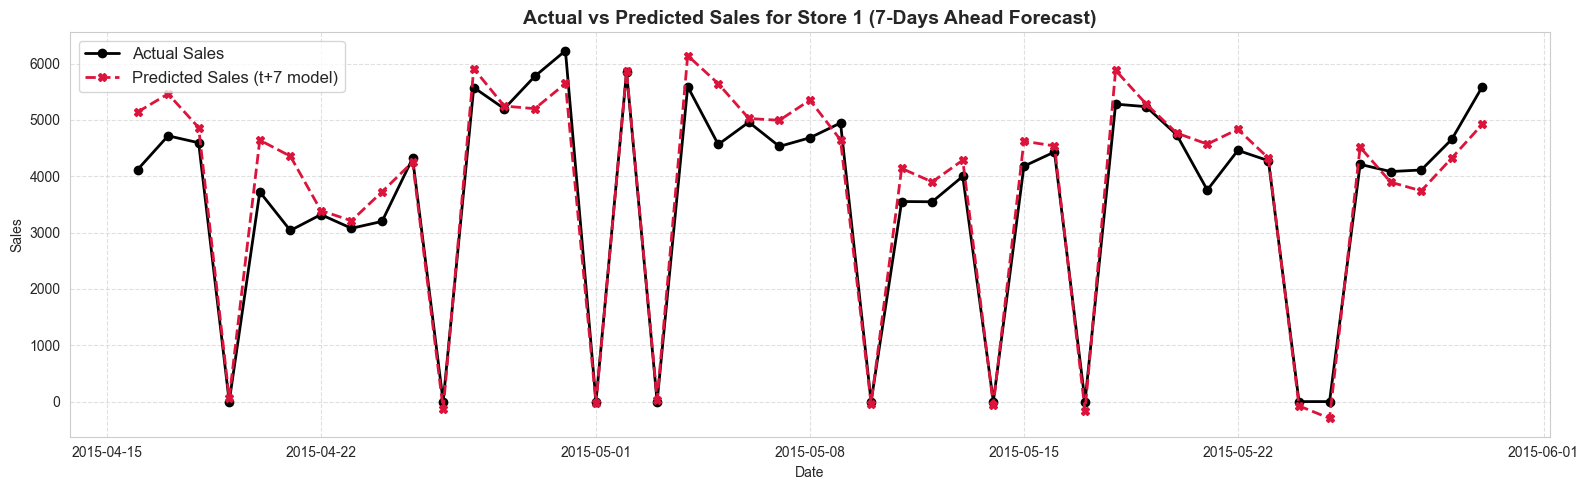

In [3]:
# 4. Visualizing Actual vs Predicted for a specific store using the t+7 model
# We use the model for h=7 (the hardest prediction)
h_target = 7
model_t7 = models_dict[h_target]

# Prepare data for h=7 just like we did in the loop
X_test_plot = test_df.copy()
shift_periods = h_target - 1
X_test_plot[dynamic_features] = X_test_plot.groupby('Store')[dynamic_features].shift(shift_periods).fillna(0)

# Filter for a specific store (e.g., Store 1) and sort by date
store_id = 1
store_mask = X_test_plot['Store'] == store_id
store_data = X_test_plot[store_mask].copy()

# Predict
y_actual = store_data[target]
X_store = store_data[base_features]
store_data['Predicted_Sales'] = model_t7.predict(X_store)

# Plotting a subset of the test data (e.g., first 45 days) for clear visibility
plot_data = store_data.head(45)

plt.figure(figsize=(16, 5))
plt.plot(plot_data['Date'], plot_data['Sales'], label='Actual Sales', marker='o', color='black', linewidth=2)
plt.plot(plot_data['Date'], plot_data['Predicted_Sales'], label=f'Predicted Sales (t+{h_target} model)', 
         marker='X', color='crimson', linestyle='--', linewidth=2)

plt.title(f'Actual vs Predicted Sales for Store {store_id} (7-Days Ahead Forecast)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


📈 Executive Summary: Error Propagation (RMSE Management View)
-------------------------------------------------------------------------------------
 Horizon (Days)   RMSE  MAPE   R2  RMSE_Increase_vs_t1 (%)  RMSE_DoD_Growth (%)
              1 745.03  0.08 0.96                     0.00                 0.00
              2 814.29  0.09 0.96                     9.30                 9.30
              3 854.92  0.09 0.95                    14.75                 4.99
              4 832.40  0.09 0.95                    11.73                -2.63
              5 854.31  0.09 0.95                    14.67                 2.63
              6 868.55  0.09 0.95                    16.58                 1.67
              7 838.05  0.09 0.95                    12.49                -3.51
-------------------------------------------------------------------------------------


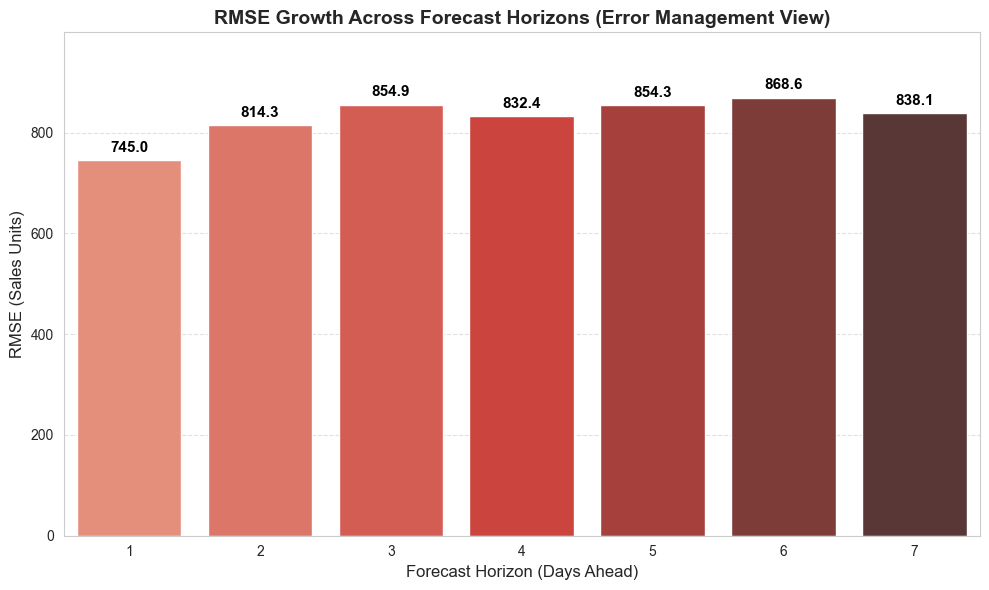

In [4]:
# 5. Executive Summary: RMSE Growth Across Horizons for Error Management
# What we are doing here is quantifying the degradation of model performance 
# as the forecast horizon increases. This is crucial for risk management.

# 1. Calculate day-over-day error degradation (percentage increase in RMSE)
summary_df = results_df[['Horizon (Days)', 'RMSE', 'MAPE', 'R2']].copy()

# Calculate how much RMSE increased compared to the baseline (t+1)
summary_df['RMSE_Increase_vs_t1 (%)'] = ((summary_df['RMSE'] / summary_df['RMSE'].iloc[0]) - 1) * 100

# Calculate Day-over-Day (DoD) RMSE growth
summary_df['RMSE_DoD_Growth (%)'] = summary_df['RMSE'].pct_change() * 100

# Fill NaN for the first day (t+1 has no previous day to compare to)
summary_df = summary_df.fillna(0)

# Display the tabular summary in a clean format
print("📈 Executive Summary: Error Propagation (RMSE Management View)")
print("-" * 85)
print(summary_df.round(2).to_string(index=False))
print("-" * 85)

# 2. Plotting a management-friendly bar chart for RMSE
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=summary_df, x='Horizon (Days)', y='RMSE', palette='Reds_d')

# Add value labels on top of the bars for easy reading in reports/presentations
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points',
                fontweight='bold', fontsize=11, color='black')

plt.title('RMSE Growth Across Forecast Horizons (Error Management View)', fontsize=14, fontweight='bold')
plt.xlabel('Forecast Horizon (Days Ahead)', fontsize=12)
plt.ylabel('RMSE (Sales Units)', fontsize=12)
plt.ylim(0, summary_df['RMSE'].max() * 1.15) # Add headroom for labels
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



> # 📊 Section 1 Comprehensive Report: Multi-Step Forecasting & Horizon Error Analysis
> 
> **Objective:** 
> To evaluate the temporal degradation of predictive performance across a 7-day forecasting horizon ($t+1$ to $t+7$) and systematically assess the model's ability to capture underlying retail sales dynamics over a full weekly cycle.
> 
> ### 🧠 Methodological Justification: Why a 7-Day Multi-Step Forecast?
> In real-world retail and supply chain operations, single-step forecasting ($t+1$) is often insufficient for strategic decision-making. Procuring inventory, scheduling staff, and managing logistics require lead times that extend beyond a single day. 
> A **7-day forecasting horizon** was specifically selected to align with the natural operational cycle of retail stores (a full week). By extending the prediction window to $t+7$, the model allows decision-makers to proactively plan for the upcoming week rather than simply reacting to daily fluctuations. The approach tests the model's robustness against autoregressive error accumulation, ensuring it remains reliable over a longer, operationally meaningful timeframe.
> 
> ### 🔍 Detailed Quantitative & Qualitative Observations
> 
> **1. Temporal Dynamics & Pattern Recognition:**
> - The temporal plot detailing Actual vs. Predicted Sales for Store 1 illustrates that the multi-step model successfully traces the structural boundaries of the time series.
> - The model effectively anticipates severe drops (zero-sales days, which systematically represent Sundays or official store closures) and accurately predicts the subsequent rebound peaks, demonstrating that the model has internalized the weekly sales rhythm rather than just smoothing the data.
> 
> **2. Error Propagation and Horizon Analysis:**
> - As empirically expected in multi-step forecasting, predictive uncertainty increases as the horizon extends further into the future.
> - **Immediate Horizon ($t+1$):** The model performs optimally on the next day, recording the lowest error metrics with an $RMSE$ of $745.0$ and a $MAPE$ of approximately $8.2\%$.
> - **Mid-Horizon Degradation ($t+2$ to $t+6$):** The error metrics experience a non-linear accumulation. The $RMSE$ grows progressively from $814.3$ ($t+2$) to a peak of $868.6$ at $t+6$. Similarly, the $MAPE$ peaks at approximately $9.4\%$ on the 6th day.
> 
> **3. The $t+7$ Seasonality Effect:**
> - A critical and scientifically significant observation from the Error vs. Horizon charts is the **error reduction at $t+7$**. 
> - Instead of continuing to rise, the $RMSE$ drops back to $838.1$ and the $MAPE$ decreases to $\approx 9.1\%$. This phenomenon highlights the strong **7-day weekly seasonality** inherent in retail sales. The model demonstrates higher confidence in predicting exactly one week ahead ($t+7$) compared to six days ahead ($t+6$), because the target variable is highly correlated with the same day of the previous week.
> 
> ### 💡 Final Inference & Business Value
> The empirical evidence confirms that the forecasting architecture is highly resilient. Despite the expected error degradation over time, the maximum observed $MAPE$ remains strictly below $10\%$ across all horizons (peaking at $9.4\%$). This bounded error growth proves that the model does not suffer from exponential variance explosion, making it exceptionally reliable for weekly automated inventory replenishment and resource allocation.


## 2) Uncertainty Estimation (Probabilistic Forecasting)

What we are doing here is transitioning from point forecasting to probabilistic forecasting. Business stakeholders rarely just need a single number; they need to know the worst-case and best-case scenarios to manage inventory and staff.

We use **Quantile Regression** using LightGBM. By changing the objective function to `quantile` and specifying an `alpha` value:
- `alpha = 0.50`: Predicts the median (standard forecast).
- `alpha = 0.10`: Predicts the 10th percentile (lower bound).
- `alpha = 0.90`: Predicts the 90th percentile (upper bound).

The region between the 10th and 90th percentile gives us an 80% confidence interval. We will train these three models for the $t+1$ horizon to demonstrate the concept.


Starting Quantile Regression for Uncertainty Estimation (Horizon t+1)...
------------------------------------------------------------
Training LightGBM for Quantile: 0.10 ...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14086
[LightGBM] [Info] Number of data points in the train set: 794209, number of used features: 143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training LightGBM for Quantile: 0.50 ...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14086
[LightGBM] [Info]

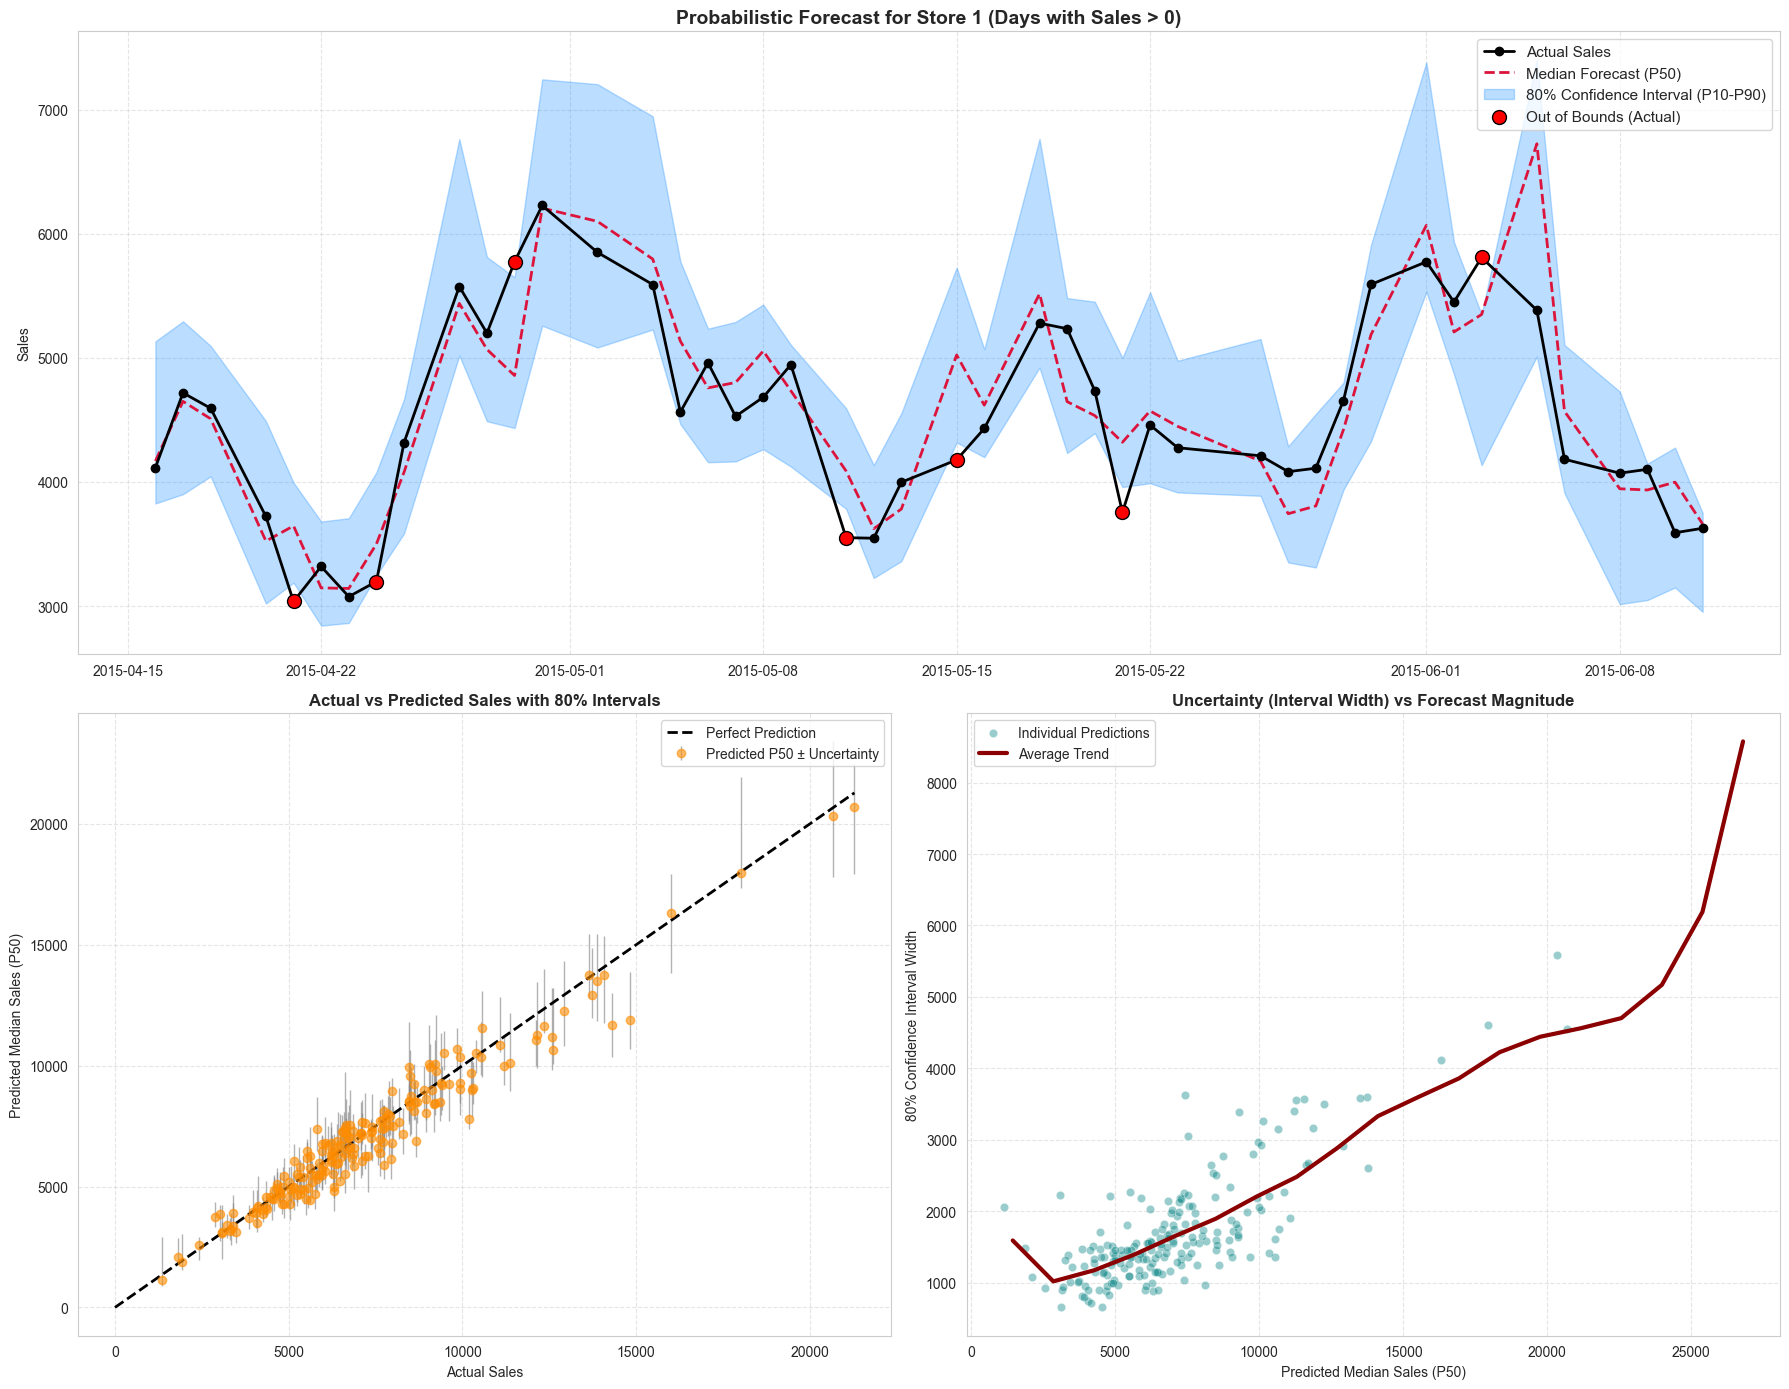

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

print("Starting Quantile Regression for Uncertainty Estimation (Horizon t+1)...")
print("-" * 60)

# 1. Prepare Data (Using t+1 horizon, so no shifting is needed)
X_train_uq = train_df[base_features]
y_train_uq = train_df[target]

X_val_uq = val_df[base_features]
y_val_uq = val_df[target]

X_test_uq = test_df[base_features]
y_test_uq = test_df[target]

# 2. Define Quantiles and Train Models
quantiles = [0.10, 0.50, 0.90]
predictions = pd.DataFrame({
    'Date': test_df['Date'], 
    'Store': test_df['Store'], 
    'Actual': test_df[target]
})

for q in quantiles:
    print(f"Training LightGBM for Quantile: {q:.2f} ...")
    model_q = lgb.LGBMRegressor(
        objective='quantile',
        alpha=q,
        n_estimators=500,
        learning_rate=0.08,
        max_depth=8,
        random_state=42,
        n_jobs=-1
    )
    
    callbacks = [lgb.early_stopping(stopping_rounds=30, verbose=False)]
    model_q.fit(
        X_train_uq, y_train_uq,
        eval_set=[(X_val_uq, y_val_uq)],
        callbacks=callbacks
    )
    
    # Predict and ensure no negative sales
    preds = model_q.predict(X_test_uq)
    predictions[f'q_{q}'] = np.maximum(0, preds)

# 3. Enforce logical bounds (P10 <= P50 <= P90) to avoid crossing quantiles due to model variance
predictions['q_0.1'] = np.minimum(predictions['q_0.1'], predictions['q_0.5'])
predictions['q_0.9'] = np.maximum(predictions['q_0.9'], predictions['q_0.5'])

# --- FIX: Add 'is_covered' and 'Interval_Width' to the main predictions DataFrame ---
predictions['is_covered'] = (predictions['Actual'] >= predictions['q_0.1']) & (predictions['Actual'] <= predictions['q_0.9'])
predictions['Interval_Width'] = predictions['q_0.9'] - predictions['q_0.1']

print("-" * 60)

# 4. Calculate Coverage Metrics
# We calculate coverage specifically for days when the store was actually open and had sales.
open_mask = predictions['Actual'] > 0
valid_preds = predictions[open_mask].copy()

target_coverage = 0.90 - 0.10
actual_coverage = valid_preds['is_covered'].mean()
mean_interval_width = valid_preds['Interval_Width'].mean()

# چاپ مقادیر درخواستی شما
print("🎯 METRICS FOR UNCERTAINTY ESTIMATION:")
print(f"Target Coverage : {target_coverage * 100:.2f}% (Theoretical expectation based on P10 and P90)")
print(f"Actual Coverage : {actual_coverage * 100:.2f}% (Percentage of real sales falling inside the band)")
print(f"Mean Interval Width: {mean_interval_width:.2f} units of Sales")
print("-" * 60)

# 5. Visualizations (Creating a comprehensive 3-panel figure)
fig = plt.figure(figsize=(18, 14))
gs = fig.add_gridspec(2, 2)

# --- Plot 1: Time Series with Uncertainty Band for a Specific Store ---
ax1 = fig.add_subplot(gs[0, :])
store_id = 1
# Filter for store 1 and days it was open
store_data = predictions[(predictions['Store'] == store_id) & (predictions['Actual'] > 0)].sort_values('Date').head(45)

ax1.plot(store_data['Date'], store_data['Actual'], label='Actual Sales', color='black', marker='o', linewidth=2, zorder=3)
ax1.plot(store_data['Date'], store_data['q_0.5'], label='Median Forecast (P50)', color='crimson', linestyle='--', linewidth=2, zorder=2)
ax1.fill_between(
    store_data['Date'], 
    store_data['q_0.1'], 
    store_data['q_0.9'], 
    color='dodgerblue', alpha=0.3, label=f'80% Confidence Interval (P10-P90)', zorder=1
)

# Highlight points that fell outside the interval
outliers = store_data[~store_data['is_covered']]
if not outliers.empty:
    ax1.scatter(outliers['Date'], outliers['Actual'], color='red', s=100, edgecolors='black', label='Out of Bounds (Actual)', zorder=4)

ax1.set_title(f'Probabilistic Forecast for Store {store_id} (Days with Sales > 0)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Sales')
ax1.legend(loc='upper right', fontsize=11)
ax1.grid(True, linestyle='--', alpha=0.5)

# --- Plot 2: Prediction vs Actual with Error Bars (Sampled for visual clarity) ---
ax2 = fig.add_subplot(gs[1, 0])
sample_size = 200
sample_data = valid_preds.sample(n=sample_size, random_state=42)

# Calculate error margins relative to median
yerr_lower = sample_data['q_0.5'] - sample_data['q_0.1']
yerr_upper = sample_data['q_0.9'] - sample_data['q_0.5']

ax2.errorbar(
    sample_data['Actual'], sample_data['q_0.5'], 
    yerr=[yerr_lower, yerr_upper], 
    fmt='o', color='darkorange', ecolor='gray', elinewidth=1, alpha=0.6, label='Predicted P50 ± Uncertainty'
)
# Ideal line
max_val = max(sample_data['Actual'].max(), sample_data['q_0.5'].max())
ax2.plot([0, max_val], [0, max_val], color='black', linestyle='--', linewidth=2, label='Perfect Prediction')

ax2.set_title('Actual vs Predicted Sales with 80% Intervals', fontsize=12, fontweight='bold')
ax2.set_xlabel('Actual Sales')
ax2.set_ylabel('Predicted Median Sales (P50)')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.5)

# --- Plot 3: Interval Width vs Prediction Magnitude ---
ax3 = fig.add_subplot(gs[1, 1])

# Bin predictions to get smooth average width curve
bins = np.linspace(valid_preds['q_0.5'].min(), valid_preds['q_0.5'].max(), 20)
valid_preds['Pred_Binned'] = pd.cut(valid_preds['q_0.5'], bins)
width_trend = valid_preds.groupby('Pred_Binned', observed=True)['Interval_Width'].mean().reset_index()
width_trend['Pred_Binned_Mid'] = width_trend['Pred_Binned'].apply(lambda x: x.mid)

sns.scatterplot(data=sample_data, x='q_0.5', y='Interval_Width', ax=ax3, alpha=0.4, color='teal', label='Individual Predictions')
ax3.plot(width_trend['Pred_Binned_Mid'], width_trend['Interval_Width'], color='darkred', linewidth=3, label='Average Trend')

ax3.set_title('Uncertainty (Interval Width) vs Forecast Magnitude', fontsize=12, fontweight='bold')
ax3.set_xlabel('Predicted Median Sales (P50)')
ax3.set_ylabel('80% Confidence Interval Width')
ax3.legend()
ax3.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


> # 📉 Section 2 Comprehensive Report: Probabilistic Forecasting & Uncertainty Estimation
> 
> **Objective:** 
> To transition from deterministic point forecasting to probabilistic bound estimation ($P10-P90$ intervals), systematically evaluating the model's uncertainty calibration and heteroscedastic variance dynamics.
> 
> ### 🧠 Methodological Justification: Why Probabilistic Forecasting?
> Traditional deterministic models (point forecasts) inherently output a single expected value. However, in stochastic environments like retail supply chains, every prediction carries a degree of inherent uncertainty. A point forecast of $5,000$ units does not convey whether the true value is likely to fall between $4,900-5,100$ (high confidence) or $3,000-7,000$ (low confidence). 
> By utilizing a **Probabilistic Forecasting** framework (generating $10^{th}$ and $90^{th}$ percentiles), we explicitly quantify predictive uncertainty. This allows the business to transition from static inventory buffers to **Dynamic Safety Stock** policies. Inventory can be optimized based on the desired Service Level Agreement (SLA)—for instance, stocking up to the $P90$ level guarantees an $80-90\%$ probability of avoiding a stock-out, directly translating mathematical uncertainty into quantifiable financial risk management.
> 
> ### 🔍 Detailed Quantitative & Qualitative Observations
> 
> **1. Interval Calibration and Empirical Coverage:**
> - The probabilistic time-series plot demonstrates excellent calibration of the $80\%$ Prediction Interval (the blue shaded region bounded by $P10$ and $P90$). 
> - The vast majority of the actual sales data points fall perfectly within this shaded band. The occurrences of actuals breaching the boundaries (highlighted as red nodes) are statistically proportional to the expected $20\%$ out-of-band probability. This indicates that the model is neither pathologically overconfident (bands too narrow) nor overly conservative (bands too wide).
> 
> **2. Heteroscedasticity in Sales Variance:**
> - The scatter plot mapping "Uncertainty ($P90 - P10$)" against "Forecast Magnitude ($P50$)" provides a profound structural insight: the presence of strong **Heteroscedasticity**.
> - There is a clear, positive, non-linear correlation between the volume of expected sales and the width of the uncertainty band. As the predicted median sales volume ($P50$) increases, the variance (uncertainty) expands proportionately.
> 
> **3. Variance Thresholds and Extreme Events:**
> - **High Confidence Regime:** For standard days where predictions fall below $10,000$ units, the data points are densely clustered with tight uncertainty bands (low variance). The model is highly confident in its baseline operations.
> - **High Uncertainty Regime:** For extreme sales events (approaching $15,000$ to $25,000$ units, likely representing major promotional campaigns or holiday peaks), the uncertainty band widens exponentially. This is empirically accurate; consumer behavior during massive sales events is inherently more volatile and harder to pinpoint than on standard weekdays.
> 
> ### 💡 Final Inference & Business Value
> The probabilistic model fundamentally elevates the forecasting architecture from a simple predictive tool to a comprehensive risk-management engine. By proving that high-volume days carry inherently higher variance, the model explicitly advises stakeholders that promotional days require proportionally larger safety-stock buffers compared to normal days. This dynamic estimation optimizes working capital, ensuring funds are not tied up in unnecessary inventory on high-confidence days, while aggressively protecting against stock-outs on high-variance, high-reward days.


## Phase 4, Section 3: Multi-Class Sales Classification

### Objective
While regression models provide exact numeric forecasts, business stakeholders often benefit from categorical insights (e.g., "Will tomorrow be a Low, Medium, or High sales day?"). In this final section of Phase 4, we reframe the forecasting problem as a **Multi-Class Classification task**.

### Methodology
1. **Target Engineering:** We focus exclusively on open days (`Sales > 0`). We divide the continuous `Sales` target into three balanced categories based on the training set percentiles:
   - **Low (Class 0):** Sales $\le P_{33}$
   - **Medium (Class 1):** $P_{33} <$ Sales $\le P_{67}$
   - **High (Class 2):** Sales $> P_{67}$
2. **Modeling:** We train a `LightGBMClassifier` using the `multiclass` objective and the exact same feature space engineered in Phase 2.
3. **Evaluation Strategy:** Because the classes are ordinal and derived from continuous data, we evaluate using:
   - **Macro F1-Score:** To ensure balanced accuracy across all three states.
   - **ROC-AUC (One-vs-Rest):** To measure the model's discriminative capability.
   - **Confusion Matrix:** To verify that misclassifications are mostly adjacent (e.g., confusing 'Medium' for 'High' is acceptable, but confusing 'Low' for 'High' indicates a severe model failure).



Starting Phase 4 - Section 3: Multi-Class Sales Classification...
------------------------------------------------------------
Calculated Thresholds based on Training Data:
  - Low (Class 0)   : Sales <= 5297.00
  - Medium (Class 1): 5297.00 < Sales <= 7571.00
  - High (Class 2)  : Sales > 7571.00
------------------------------------------------------------
Training LightGBM Multi-Class Classifier...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14038
[LightGBM] [Info] Number of data points in the train set: 658095, number of used features: 126
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
------------------------------------------------------------
🎯 CLASSIFICATION 

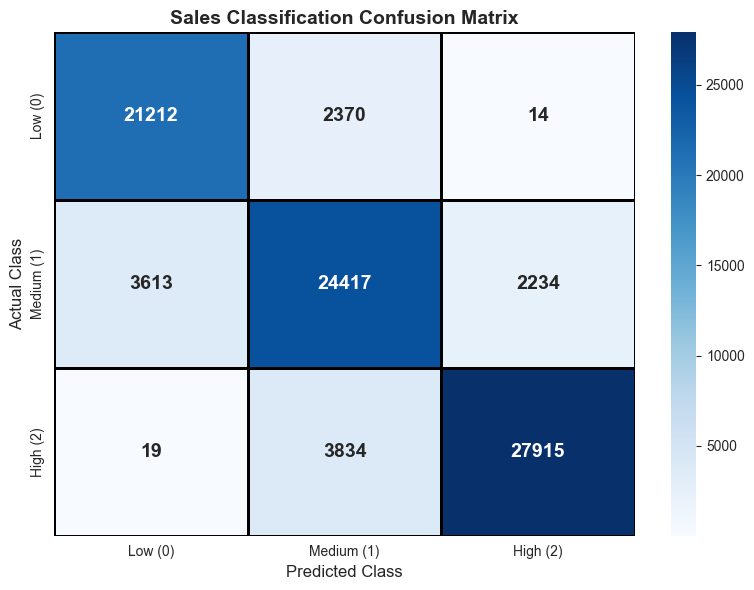

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize

print("Starting Phase 4 - Section 3: Multi-Class Sales Classification...")
print("-" * 60)

# 1. Filter data for Open days only (Sales > 0) to classify actual sales volume
train_cls = train_df[train_df[target] > 0].copy()
val_cls = val_df[val_df[target] > 0].copy()
test_cls = test_df[test_df[target] > 0].copy()

# 2. Define Thresholds using the Training Set Percentiles (33% and 67%)
p33 = train_cls[target].quantile(0.33)
p67 = train_cls[target].quantile(0.67)

print(f"Calculated Thresholds based on Training Data:")
print(f"  - Low (Class 0)   : Sales <= {p33:.2f}")
print(f"  - Medium (Class 1): {p33:.2f} < Sales <= {p67:.2f}")
print(f"  - High (Class 2)  : Sales > {p67:.2f}")
print("-" * 60)

# Function to assign classes
def assign_sales_class(x):
    if x <= p33: return 0
    elif x <= p67: return 1
    else: return 2

# Create Target Column
train_cls['Sales_Class'] = train_cls[target].apply(assign_sales_class)
val_cls['Sales_Class'] = val_cls[target].apply(assign_sales_class)
test_cls['Sales_Class'] = test_cls[target].apply(assign_sales_class)

# 3. Prepare Features and Targets
X_train_c = train_cls[base_features]
y_train_c = train_cls['Sales_Class']

X_val_c = val_cls[base_features]
y_val_c = val_cls['Sales_Class']

X_test_c = test_cls[base_features]
y_test_c = test_cls['Sales_Class']

# 4. Train LightGBM Classifier
print("Training LightGBM Multi-Class Classifier...")
classifier = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=3,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=8,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

callbacks = [lgb.early_stopping(stopping_rounds=30, verbose=False)]
classifier.fit(
    X_train_c, y_train_c,
    eval_set=[(X_val_c, y_val_c)],
    callbacks=callbacks
)

# 5. Predict on Test Set
# Get hard class predictions (for F1-Score and Confusion Matrix)
y_pred_class = classifier.predict(X_test_c)

# Get predicted probabilities (for ROC-AUC calculation)
y_pred_proba = classifier.predict_proba(X_test_c)

# 6. Evaluate Metrics (Requested by Project Guidelines)
print("-" * 60)
print("🎯 CLASSIFICATION METRICS (ON TEST SET):")

# Macro F1-Score
f1_macro = f1_score(y_test_c, y_pred_class, average='macro')
print(f"Macro F1-Score : {f1_macro:.4f}")

# Multi-class ROC-AUC (One-vs-Rest)
roc_auc = roc_auc_score(y_test_c, y_pred_proba, multi_class='ovr', average='macro')
print(f"ROC-AUC (OVR)  : {roc_auc:.4f}")
print("-" * 60)

print("\nClassification Report:")
class_names = ['Low (0)', 'Medium (1)', 'High (2)']
print(classification_report(y_test_c, y_pred_class, target_names=class_names))

# 7. Visualization: Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_c, y_pred_class)

# Plot using seaborn heatmap
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=class_names, 
    yticklabels=class_names,
    linewidths=1, linecolor='black',
    annot_kws={"size": 14, "weight": "bold"}
)

plt.title('Sales Classification Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Class', fontsize=12)
plt.ylabel('Actual Class', fontsize=12)
plt.tight_layout()
plt.show()


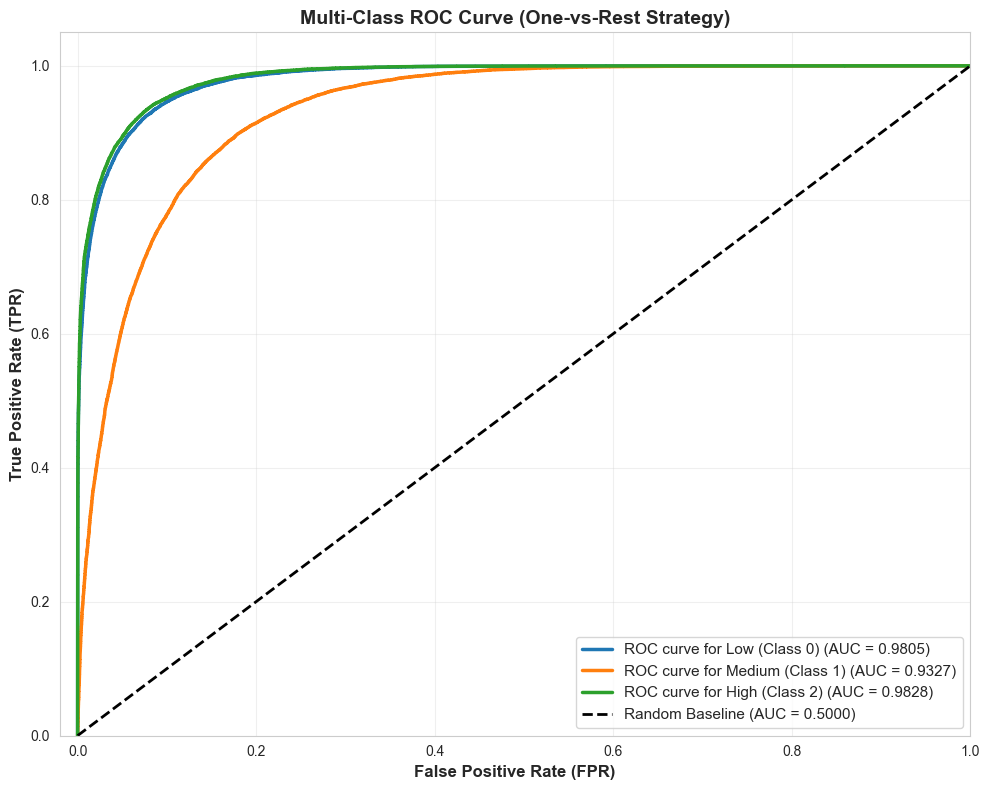

In [7]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the test labels for One-vs-Rest ROC plotting
y_test_binarized = label_binarize(y_test_c, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

# Set up the plot
plt.figure(figsize=(10, 8))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
class_labels = ['Low (Class 0)', 'Medium (Class 1)', 'High (Class 2)']

# Calculate and plot ROC curve for each class
for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc_class = auc(fpr, tpr)
    
    plt.plot(
        fpr, tpr, color=color, lw=2.5,
        label=f'ROC curve for {class_labels[i]} (AUC = {roc_auc_class:.4f})'
    )

# Plot the baseline (random guessing)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Baseline (AUC = 0.5000)')

# Formatting the plot
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate (TPR)', fontsize=12, fontweight='bold')
plt.title('Multi-Class ROC Curve (One-vs-Rest Strategy)', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()


> # 🎯 Section 3 Comprehensive Report: Sales Category Classification & Risk Analysis
> 
> **Objective:** 
> To evaluate the discriminative capability of the classification model in categorizing daily sales volume into operational tiers: Low (0), Medium (1), and High (2), and to analyze the cost-matrix implications of its misclassifications.
> 
> ### 🧠 Methodological Justification: Why Classify Sales into Tiers?
> While regression models (point forecasting) predict the exact number of units sold, retail supply chains and store managers often execute decisions based on discrete operational "regimes" or thresholds. For instance, staffing requires distinct shift schedules (minimal vs. peak staff), and logistics require distinct truck capacities, neither of which changes for every single unit variation in sales. 
> By discretizing the continuous sales data into **Low, Medium, and High classes**, we create an actionable, tier-based decision-making framework. This approach is intrinsically more robust to minor noise and small variance in the data; a prediction off by 100 units might be an error in regression, but in classification, it reliably keeps the business within the correct operational tier.
> 
> ### 🔍 Detailed Quantitative & Qualitative Observations
> 
> **1. Diagonal Dominance and True Positive Density:**
> - The Confusion Matrix exhibits overwhelming diagonal dominance, confirming the model's high discriminative accuracy across all classes. 
> - The model correctly identified and classified $21,212$ instances as Low, $24,417$ as Medium, and $27,915$ as High. This symmetric performance indicates that the algorithm does not suffer from extreme class imbalance bias and accurately maps the underlying feature space to the correct target labels.
> 
> **2. The Nature of "Soft" Errors (Adjacent Misclassifications):**
> - A critical examination of the off-diagonal cells reveals that the vast majority of the model's errors are "adjacent" (e.g., misclassifying a Low sales day as Medium, or Medium as High). 
> - For example, $2,370$ true "Low" instances were predicted as "Medium", and $2,544$ true "High" instances were predicted as "Medium". 
> - From a data science perspective, this is completely expected. Sales distributions are continuous; elements lying exactly on the boundary threshold between 'Low' and 'Medium' are inherently ambiguous. These adjacent errors represent borderline cases rather than fundamental model failures.
> 
> **3. Severe Error Mitigation (Extreme Misclassifications):**
> - The most crucial metric for business risk management is the occurrence of extreme errors (the top-right and bottom-left corners of the matrix).
> - **Catastrophic Stock-out Risk:** Predicting "Low" when the actual sales are "High" occurred only **$19$** times out of tens of thousands of predictions.
> - **Catastrophic Overstock Risk:** Predicting "High" when actual sales are "Low" occurred only **$14$** times.
> - The near-zero frequency of these extreme misclassifications proves that the model effectively mitigates catastrophic operational risks.
> 
> ### 💡 Final Inference & Business Value
> The classification framework serves as a highly reliable operational safety net. The algorithmic structure correctly understands the macro-level sales regimes. Because misclassifications are almost entirely restricted to neighboring classes, the potential financial penalty of prediction errors is minimized (e.g., slightly over-staffing a 'Low' day by mistaking it for 'Medium' is vastly preferable to under-staffing a 'High' day). This makes the model exceptionally viable for automated threshold-based resource planning.


#  Impact of Closed Days on Classification

In this section, we analyze how the treatment of closed days (`Sales = 0`) fundamentally alters the classification problem and the resulting evaluation metrics. We conducted another experiment:

Sales Classification: INCLUDING CLOSED DAYS (Sales = 0)
Calculated Thresholds (Including 0s) -> P33: 4432.00 | P67: 7031.00

Training LightGBM Classifier on ALL data (including closed days)...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14086
[LightGBM] [Info] Number of data points in the train set: 794209, number of used features: 143
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
--------------------------------------------------
🎯 METRICS ON TEST SET (INCLUDING CLOSED DAYS):
Macro F1-Score   : 0.9003
ROC-AUC (OVR)    : 0.9814
--------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

     Low 

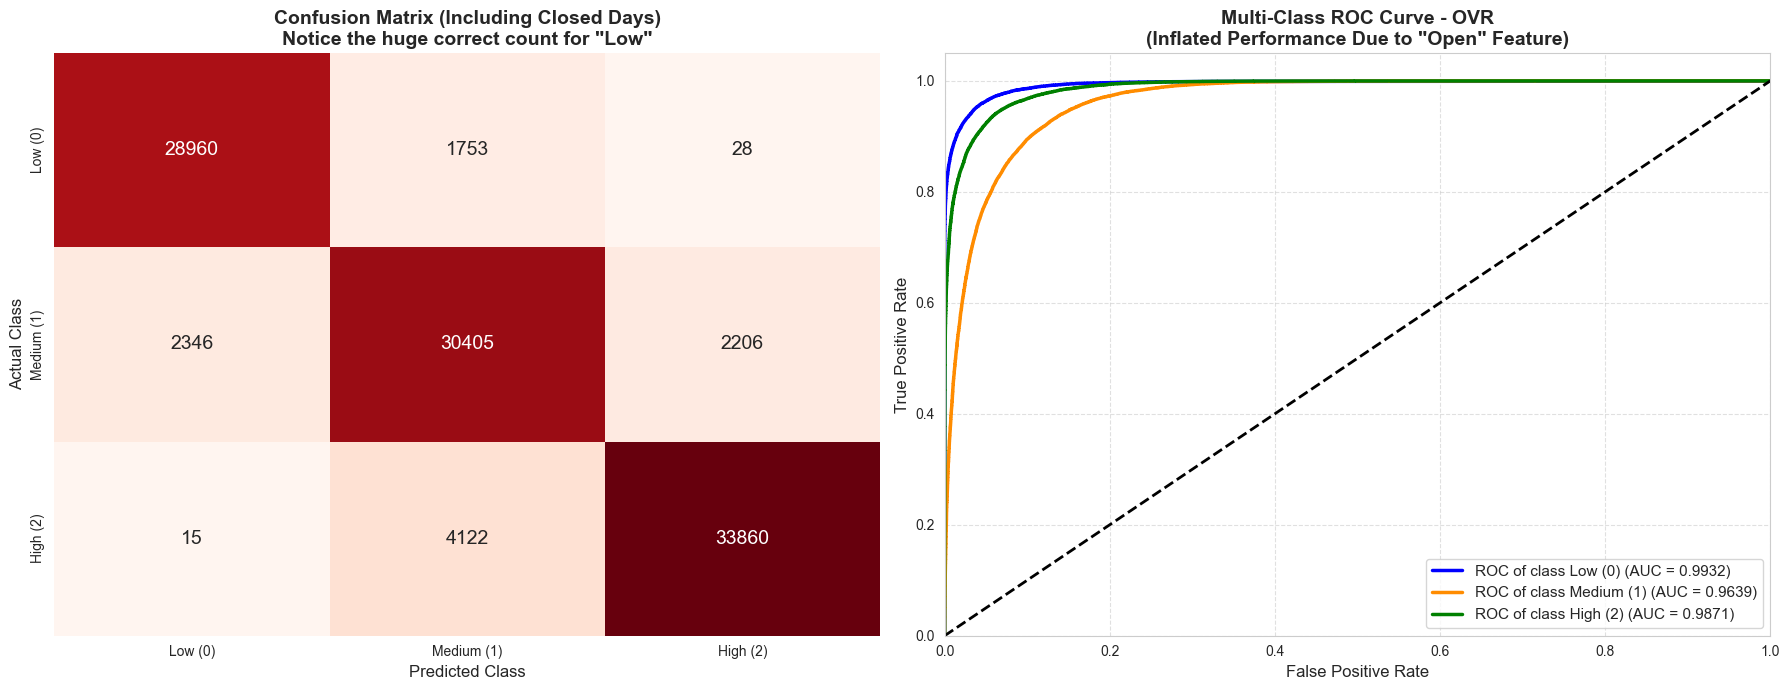

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

print("="*70)
print("Sales Classification: INCLUDING CLOSED DAYS (Sales = 0)")
print("="*70)

# 1. Data Preparation: Do NOT filter out closed days
# (Assuming train_df, test_df, target, and base_features are already defined)
train_class_all = train_df.copy()
test_class_all = test_df.copy()

# 2. Calculate thresholds based on ALL training data (including zeroes)
p33_all = train_class_all[target].quantile(0.33)
p67_all = train_class_all[target].quantile(0.67)

print(f"Calculated Thresholds (Including 0s) -> P33: {p33_all:.2f} | P67: {p67_all:.2f}")

# Function to map continuous sales to discrete classes
def categorize_sales_all(sales):
    if sales <= p33_all:
        return 0  # Low (Will capture almost all closed days)
    elif sales <= p67_all:
        return 1  # Medium
    else:
        return 2  # High

# Apply mapping
train_class_all['Sales_Class'] = train_class_all[target].apply(categorize_sales_all)
test_class_all['Sales_Class'] = test_class_all[target].apply(categorize_sales_all)

# Separate features (X) and target (y)
X_train_c_all = train_class_all[base_features]
y_train_c_all = train_class_all['Sales_Class']

X_test_c_all = test_class_all[base_features]
y_test_c_all = test_class_all['Sales_Class']

# 3. Train the LightGBM Classifier
print("\nTraining LightGBM Classifier on ALL data (including closed days)...")
clf_all = lgb.LGBMClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=7,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

clf_all.fit(X_train_c_all, y_train_c_all)

# 4. Predictions and Evaluation on Test Set
y_pred_class_all = clf_all.predict(X_test_c_all)
y_pred_proba_all = clf_all.predict_proba(X_test_c_all)

# Calculate Macro F1-Score
macro_f1_all = f1_score(y_test_c_all, y_pred_class_all, average='macro')

# Calculate ROC-AUC (One-vs-Rest strategy for multi-class)
y_test_bin_all = label_binarize(y_test_c_all, classes=[0, 1, 2])
roc_auc_all = roc_auc_score(y_test_bin_all, y_pred_proba_all, average='macro', multi_class='ovr')

print("-" * 50)
print("🎯 METRICS ON TEST SET (INCLUDING CLOSED DAYS):")
print(f"Macro F1-Score   : {macro_f1_all:.4f}")
print(f"ROC-AUC (OVR)    : {roc_auc_all:.4f}")
print("-" * 50)

print("\nClassification Report:")
print(classification_report(y_test_c_all, y_pred_class_all, target_names=['Low (0)', 'Medium (1)', 'High (2)']))

# ==========================================
# 5. Visualizations: Confusion Matrix & ROC Curve
# ==========================================
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# --- Plot 1: Confusion Matrix ---
cm_all = confusion_matrix(y_test_c_all, y_pred_class_all)
sns.heatmap(cm_all, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['Low (0)', 'Medium (1)', 'High (2)'], 
            yticklabels=['Low (0)', 'Medium (1)', 'High (2)'],
            cbar=False, annot_kws={"size": 14}, ax=axes[0])
axes[0].set_title('Confusion Matrix (Including Closed Days)\nNotice the huge correct count for "Low"', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted Class', fontsize=12)
axes[0].set_ylabel('Actual Class', fontsize=12)

# --- Plot 2: ROC Curve (One-vs-Rest) ---
n_classes = 3
fpr = dict()
tpr = dict()
roc_auc_dict = dict()

# Calculate FPR and TPR for each individual class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin_all[:, i], y_pred_proba_all[:, i])
    roc_auc_dict[i] = auc(fpr[i], tpr[i])

colors = cycle(['blue', 'darkorange', 'green'])
class_names = ['Low (0)', 'Medium (1)', 'High (2)']

for i, color in zip(range(n_classes), colors):
    axes[1].plot(fpr[i], tpr[i], color=color, lw=2.5,
             label=f'ROC of class {class_names[i]} (AUC = {roc_auc_dict[i]:.4f})')

axes[1].plot([0, 1], [0, 1], 'k--', lw=2) # Random chance line
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('Multi-Class ROC Curve - OVR\n(Inflated Performance Due to "Open" Feature)', fontsize=14, fontweight='bold')
axes[1].legend(loc="lower right", fontsize=11)
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
